In [ ]:
%pip install pyroomacoustics
%pip install matplotlib=3.7 # needs a later version to work

This is just my first pass through, I haven't deleted it yet because I was using it as an example

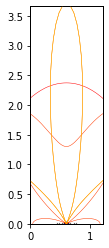

In [1]:
# import numpy as np
# import matplotlib.pyplot as plt
# import pyroomacoustics as pra

# # Recreate Dr. Neilsen's water tank by inputting the correct dimensions
# room = pra.ShoeBox([1.22,3.66])

# # Add a source somewhere in the tank
# room.add_source([.61, 0])

# # Create a linear array beamformer with 4 microphones
# # with angle 0 degrees and inter mic distance 10 cm
# # R = pra.linear_2D_array([2, 1.5], 4, 0, 0.1)
# R = pra.linear_2D_array([.61, 0], 4, 0, 0.1)
# room.add_microphone_array(pra.Beamformer(R, room.fs))

# # Now compute the delay and sum weights for the beamformer
# room.mic_array.rake_delay_and_sum_weights(room.sources[0][:1])

# # plot the room and resulting beamformer
# room.plot(freq=[1000, 2000, 4000, 8000], img_order=0)
# plt.show()

This is the one I am actually working on with (hopefully) more helpful notes in the comments. the links I was using are at the bottom of the page.

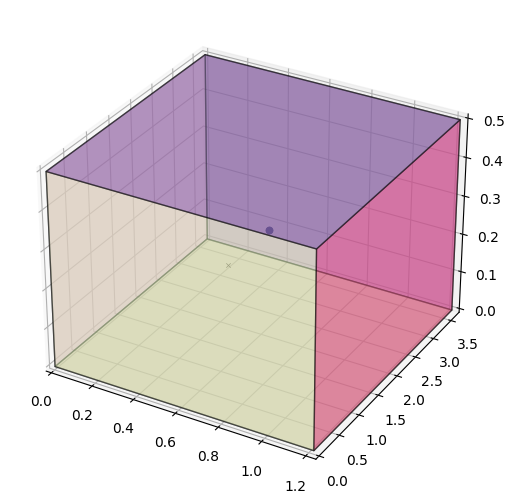

(50000.0, 100000.0)

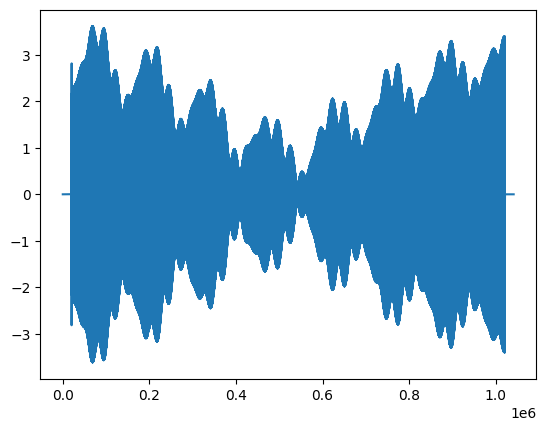

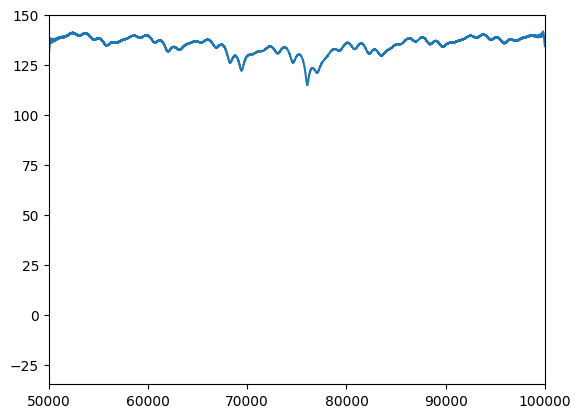

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve, chirp
import IPython
import pyroomacoustics as pra
P_REF = 1e-6
rec_location = [0.6,1.2,0.25]
src_location = [0.6,2.2,0.25]

# SRC signal generation
fs = 1e6# sampling frequency 1 MHz
t = np.arange(0,1,1/fs)
src_sig = chirp( t=t, f0=50000, f1=100000, t1=1, method='linear' )
src_sig = np.append( np.zeros((1,20000)), src_sig )
src_sig = np.append( src_sig, np.zeros((1,20000))) 

# Recreate Dr. Neilsen's water tank by inputting the correct dimensions
# I am trying to figure out how to make it so we can put absorption panels
# on the two walls, but not all 4. No luck so far. This material is closest to 
# polyurethane in their materials library- perforated_veneered_chipboard
m = pra.make_materials(
    ceiling=0.0,
    floor=0.4708,
    east=0.6089,
    west=0.6089,
    north=0.6089,
    south=0.6089,
)

room = pra.ShoeBox([1.22,3.66], fs=fs, temperature=5333, materials=m, use_rand_ism = True, max_rand_disp = 0.05) 
# temperature is in degC, but is ridiculous. speed of sound in water is ~1500m/s. this package is built for air
# Having an air temperature of 5333 gets about the same speed of sound
room.extrude(.5) # typical water depth of 0.5 m
# Floor absorption: acrylic: 0.4708
# Ceiling absorption: pressure release boundary: 0
# Wall absorption: polyurethane panels: 0.6089

# Add a source somewhere in the tank
room.add_source(src_location, signal=src_sig)

# the hydrophones can act as src or rec, but we usually have 2 hydrophones, with one as a src and one as rec
# with angle 0 degrees and inter mic distance 10 cm

mics = np.c_[rec_location]
# room.add_microphone_array(pra.Beamformer(mics, room.fs))
room.add_microphone_array(mics)


# # Now compute the delay and sum weights for the beamformer (I don't know what this means)
# Beamforming is using an array of microphones or a hydrophones to calculate the direction of arrival.
# Might be interesting but not necessary
# room.mic_array.rake_delay_and_sum_weights(room.sources[0][:1])

# plot the room and resulting beamformer (I can't get this to work, but I didn't super have time to keep
# working on it, so it might not be that bad of a fix)
room.plot(freq=[1000, 2000, 4000, 8000], img_order=0)
plt.show()

room.compute_rir()
# print(room.rir)
# plt.plot(room.rir[0][0])
# plt.show()

room.simulate()
sim_sig = room.mic_array.signals[0,:]
plt.plot(sim_sig)
# print(len(room.mic_array.signals[0,:]))
# print(len(room.rir[0][0]))
N = len(sim_sig)
sim_spec = np.sqrt( 2 / N ) * np.fft.fft( sim_sig )[0:N//2]
sim_spec = 20*np.log10(np.abs(sim_spec/P_REF))
freq = np.arange( 0, fs//2, fs/N )
plt.figure()
plt.plot(freq,sim_spec)
plt.xlim([50000,100000])


0.99


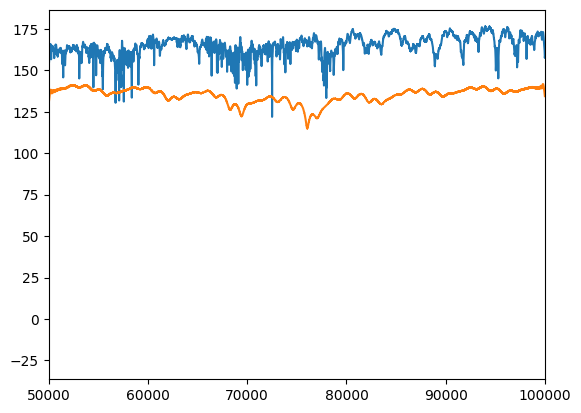

In [45]:
## Comparisons with real data
# This should load in an acoustic spectrum from some data I recorded last summer for research.
# I copied the file it loads in into the repo so it should run on your computer too.
# For these measurements, the src is at 0.6,2.2,0.5 (x,y,z)
# and the recs are at the same x and z, and y's ranging from 1.85-0.55. The range or distance from the src
# is loaded in as the range variable below. 
import h5py

meas_ID = 28 # range=1m
# meas_ID = 0
with h5py.File('scan_2023_06_29b.hdf5', 'r') as file:
    spectra = file['data'][meas_ID]
    meas_freq_array = file['freq'][:]
    range = file['range'][meas_ID]
print(range)
    
P_REF = 1e-6
spec_dB = 20*np.log10(np.abs(spectra/P_REF))
plt.figure()
plt.plot(meas_freq_array,spec_dB[1,:])
plt.plot(freq,sim_spec)
plt.xlim([50000,100000])
plt.show()

Wave Equation, modeling boundary conditions in a tank
https://pyroomacoustics.readthedocs.io/en/pypi-release/pyroomacoustics.room.html#pyroomacoustics.room.Room

Design of an underwater acoustics lab 
Cameron T. Vongsawad; 

https://hplgit.github.io/fdm-book/doc/pub/book/sphinx/._book008.html
https://github.com/LCAV/pyroomacoustics/blob/master/README.rst
https://m-sound.github.io/mSOUND/rigid_vs_pressure_release



